In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [2]:
result_files = {
    "ma2": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_2_agents_e4tot100_eval/env_rollout_images.pt",
    "ma3": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_3_agents_r7_e4tot100_eval/env_rollout_images.pt",
    "ma4": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_4_agents_e4tot100_eval/env_rollout_images.pt",
    "hex2ue": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_2_agents_hex_e4tot100_eval/env_rollout_images.pt",
    "hex3ue": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_3_agents_hex_e4tot100_eval/env_rollout_images.pt",
    "hex4ue": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_4_agents_hex_e4tot100_eval/env_rollout_images.pt",
    "r5": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_3_agents_r5_e4tot100_eval/env_rollout_images.pt",
    "r7": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_3_agents_r7_e4tot100_eval/env_rollout_images.pt",
    "r9": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_3_agents_r9_e4tot100_eval/env_rollout_images.pt",
    "r11": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_3_agents_r11_e4tot100_eval/env_rollout_images.pt",
    # "colr7": "",
    "f0": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_f0_e4tot100_eval/env_rollout_images.pt",
    "f1": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_f1_e4tot100_eval/env_rollout_images.pt",
    "f2": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_3_agents_r7_e4tot100_eval/env_rollout_images.pt",
    "f3": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_f3_e4tot100_eval/env_rollout_images.pt",
    "f4": "/home/hieule/research/saris_revised/local_assets/Hallway_L/e4tot100/hallway_focus_f4_e4tot100_eval/env_rollout_images.pt",
}

all_results = {}
for key, file_path in result_files.items():
    if os.path.exists(file_path):
        all_results[key] = torch.load(file_path, weights_only=False)
    else:
        print(f"File {file_path} does not exist.")

In [3]:
def smooth(data, window_size=5):
    """Smooth the data using a Gaussian moving average filter."""
    # first, pad the data with zeros
    pad_size = window_size + 3
    data = np.pad(data, (pad_size, pad_size), mode="edge")
    # then, apply the Gaussian moving average filter
    kernel = np.exp(-0.5 * (np.arange(-pad_size, pad_size + 1) / 1) ** 2)
    kernel /= np.sum(kernel)
    smoothed_data = np.convolve(data, kernel, mode="same")
    # remove the padding
    smoothed_data = smoothed_data[pad_size:-pad_size]
    return smoothed_data

def plot_rssi(rssis, title, ymin=-100, ymax=-55, is_smooth=True, colors=None, xvals=None):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    for key, rssi in rssis.items():
        if xvals is not None and key in xvals:
            x = xvals[key]
            rssi_mean = rssi
            ax.axhline(y=np.mean(rssi_mean), color=colors[key], linestyle='--', label=f'{key} avg: {np.mean(rssi_mean):.2f} dBm')
            ax.scatter(x, rssi_mean, label=f'{key}', alpha=0.7, color=colors[key])
        else:
            rssi_mean = rssi.mean(dim=0)[0].cpu().numpy()
            
            # smooth data for every 20 steps only
            rfsss = []
            n_last = -2
            last_n_each = []
            for i in range(0, len(rssi_mean), 20):
                tmp_rfs = rssi_mean[i:i+20]
                last_n_each.append(tmp_rfs[-n_last:])
                tmp_rfs = smooth(tmp_rfs, window_size=3)
                rfsss.append(tmp_rfs)
            if is_smooth:
                rssi_mean = np.concatenate(rfsss).reshape(-1)
            last_n_each = np.concatenate(last_n_each).reshape(-1)
            last_n_each_avg = last_n_each.mean()
            # plot the single value as a horizonaltal line of (last_n_each_avg)
            ax.axhline(y=last_n_each_avg, color=colors[key], linestyle='--', label=f'{key} avg: {last_n_each_avg:.2f} dBm')
            
            rssi_std = rssi.std(dim=0)[0].cpu().numpy()
            x = range(len(rssi_mean))
            ax.plot(x, rssi_mean, label=f'{key}', alpha=0.7, color=colors[key])
            ax.fill_between(range(len(rssi_mean)), 
                            rssi_mean - rssi_std, 
                            rssi_mean + rssi_std, 
                            alpha=0.1, color=colors[key])
    if title != "":
        ax.set_title(title, fontsize=16)
    ax.set_xlabel('Time Step', fontsize=14)
    ax.set_ylabel('RSSI (dBm)', fontsize=14)
    ax.legend(loc='lower right')
    plt.tight_layout()
    ax.grid(True)
    ax.xaxis.set_major_locator(plt.MultipleLocator(20))
    ax.set_ylim(ymin, ymax)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    return fig, ax

## Focusing

rss shape for r11: torch.Size([4, 1, 400, 3])
rss shape for r9: torch.Size([4, 1, 400, 3])
rss shape for r7: torch.Size([4, 1, 400, 3])
rss shape for r5: torch.Size([4, 1, 400, 3])


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'RSSI Over Time for Different Reflector Sizes'}, xlabel='Time Step', ylabel='RSSI (dBm)'>)

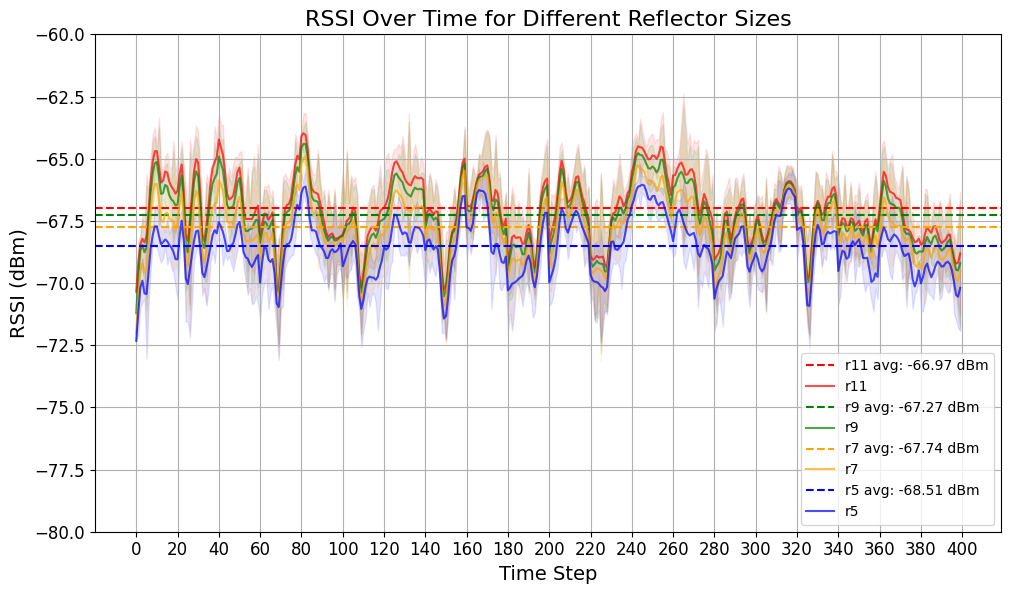

In [4]:
focusing_results = {
    "r11": all_results["r11"],
    "r9": all_results["r9"],
    "r7": all_results["r7"],
    "r5": all_results["r5"],
}
focusing_rssis = {}
for key, result in focusing_results.items():
    rss = result["agents", "cur_rss"].cpu()
    rss = [rss[..., 0, i:i+1] for i in range(rss.shape[-1])]
    rss = torch.cat(rss, dim=-1)
    print(f"rss shape for {key}: {rss.shape}")
    tmp = rss.mean(dim=-1)
    focusing_rssis[key] = 10 * torch.log10(tmp) + 30  # Convert to dBm
focusing_colors = {
        "r11": "red",
        "r9": "green",
        "r7": "orange",
        "r5": "blue",
        }
plot_rssi(focusing_rssis, "RSSI Over Time for Different Reflector Sizes", 
          ymin=-80, ymax=-60, colors=focusing_colors)

### Zoomed-in View

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'RSSI Over Time for Different Reflector Sizes'}, xlabel='Time Step', ylabel='RSSI (dBm)'>)

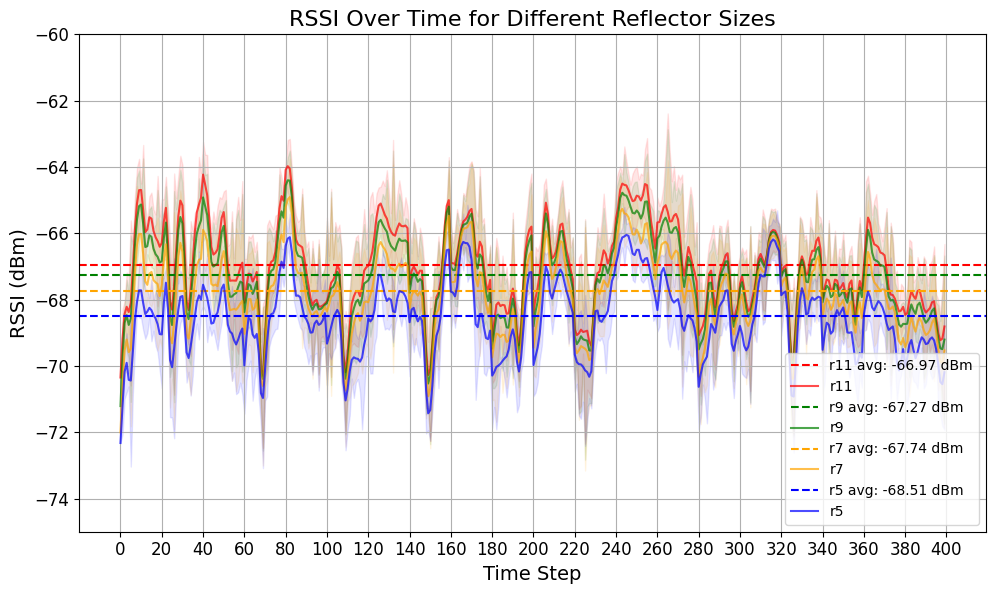

In [5]:
plot_rssi(focusing_rssis, "RSSI Over Time for Different Reflector Sizes", ymin=-75, ymax=-60, colors=focusing_colors)

### No Smooth

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'RSSI Over Time for Different Reflector Sizes'}, xlabel='Time Step', ylabel='RSSI (dBm)'>)

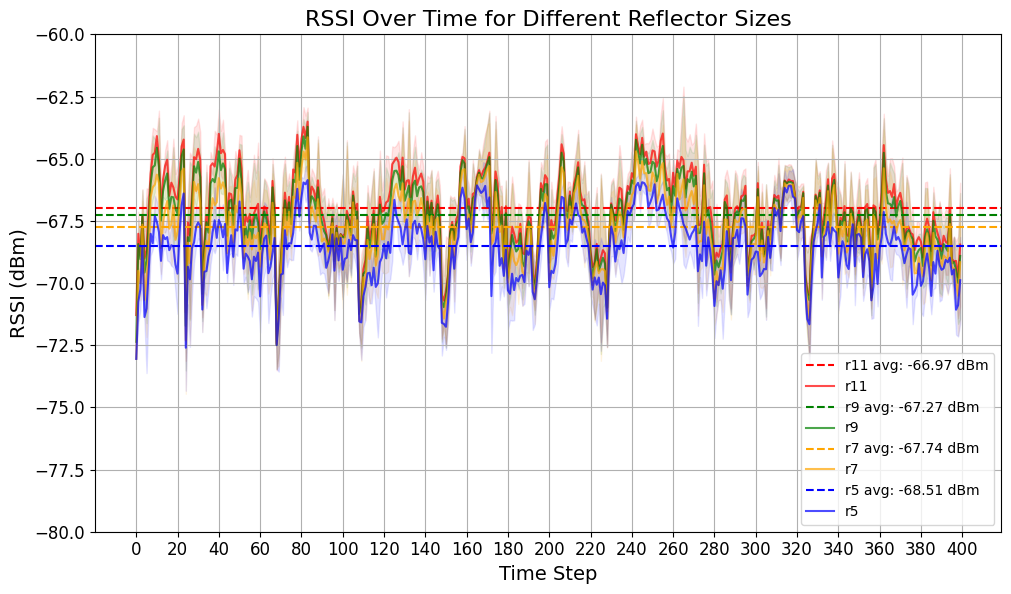

In [6]:
plot_rssi(focusing_rssis, "RSSI Over Time for Different Reflector Sizes", ymin=-80, ymax=-60, is_smooth=False, colors=focusing_colors)

## Plot RSSI with different numbers of users

rss shape for ma2: torch.Size([4, 1, 400, 2])
rss shape for ma3: torch.Size([4, 1, 400, 3])
rss shape for ma4: torch.Size([4, 1, 400, 4])


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'RSSI Over Time for Different Numbers of Users'}, xlabel='Time Step', ylabel='RSSI (dBm)'>)

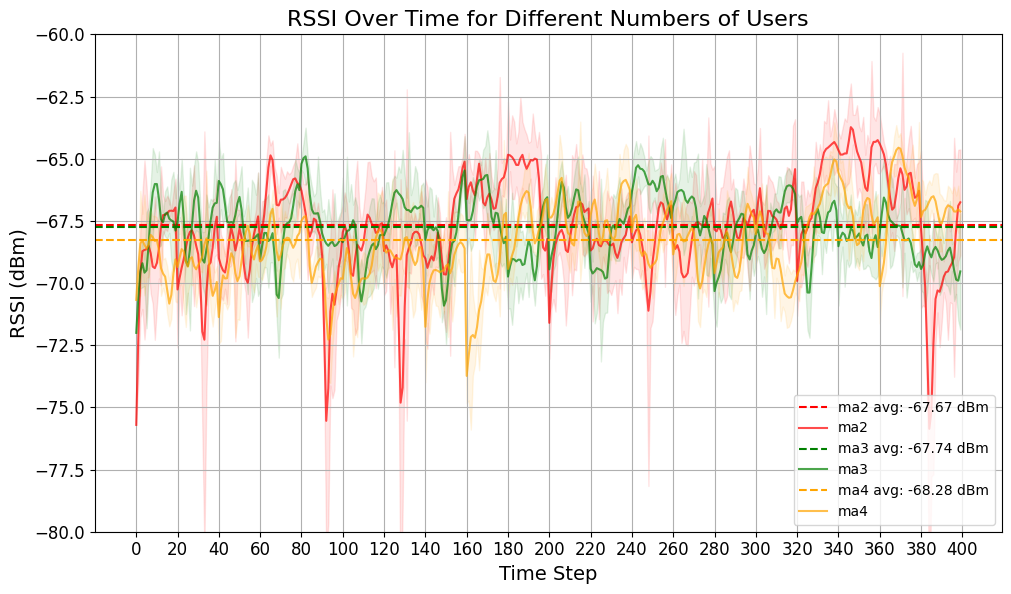

In [7]:
ma_results = {
    "ma2": all_results["ma2"],
    "ma3": all_results["ma3"],
    "ma4": all_results["ma4"],
}
ma_rssis = {}
for key, result in ma_results.items():
    rss = result["agents", "cur_rss"].cpu()
    rss = [rss[..., 0, i:i+1] for i in range(rss.shape[-1])]
    rss = torch.cat(rss, dim=-1)
    print(f"rss shape for {key}: {rss.shape}")
    tmp = rss.mean(dim=-1)
    ma_rssis[key] = 10 * torch.log10(tmp) + 30  # Convert to dBm
ma_colors = {
        "ma2": "red",
        "ma3": "green",
        "ma4": "orange",
        }
plot_rssi(ma_rssis, "RSSI Over Time for Different Numbers of Users", ymin=-80, ymax=-60, colors=ma_colors)

### Hex vs column pattern

In [8]:
pattern_results = {
    "hex2ue": all_results["hex2ue"],
    "hex3ue": all_results["hex3ue"],
    "hex4ue": all_results["hex4ue"],
    "ma2": all_results["ma2"],
    "ma3": all_results["ma3"],
    "ma4": all_results["ma4"],
}
pattern_rssis = {}
for key, result in pattern_results.items():
    rss = result["agents", "cur_rss"].cpu()
    rss = [rss[..., 0, i:i+1] for i in range(rss.shape[-1])]
    rss = torch.cat(rss, dim=-1)
    print(f"rss shape for {key}: {rss.shape}")
    tmp = rss.mean(dim=-1)
    pattern_rssis[key] = 10 * torch.log10(tmp) + 30  # Convert to dBm
pattern_colors = {
        "ma4": "red",
        "ma3": "green",
        "ma2": "blue",
        "hex4ue": "cyan",
        "hex3ue": "orange",
        "hex2ue": "magenta",
        }

rss shape for hex2ue: torch.Size([4, 1, 400, 2])
rss shape for hex3ue: torch.Size([4, 1, 400, 3])
rss shape for hex4ue: torch.Size([4, 1, 400, 4])
rss shape for ma2: torch.Size([4, 1, 400, 2])
rss shape for ma3: torch.Size([4, 1, 400, 3])
rss shape for ma4: torch.Size([4, 1, 400, 4])


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Comparison of Hex and Simple Patterns for Four-user Scenario'}, xlabel='Time Step', ylabel='RSSI (dBm)'>)

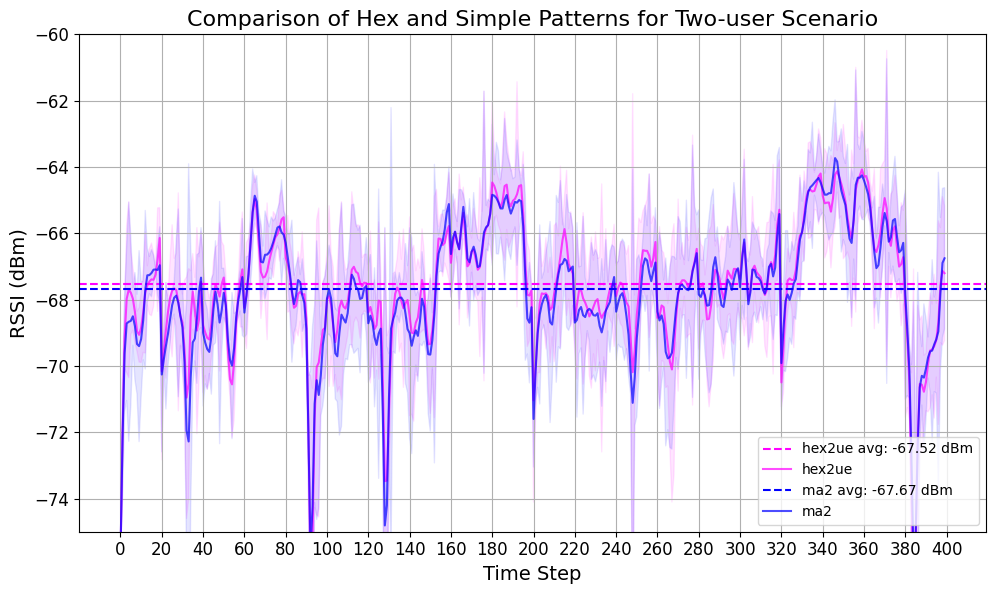

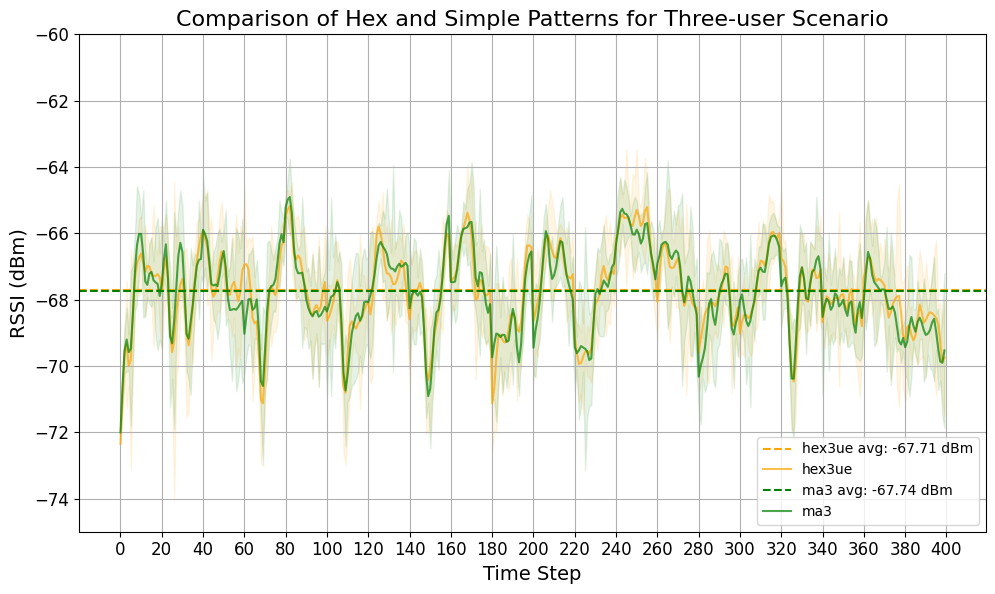

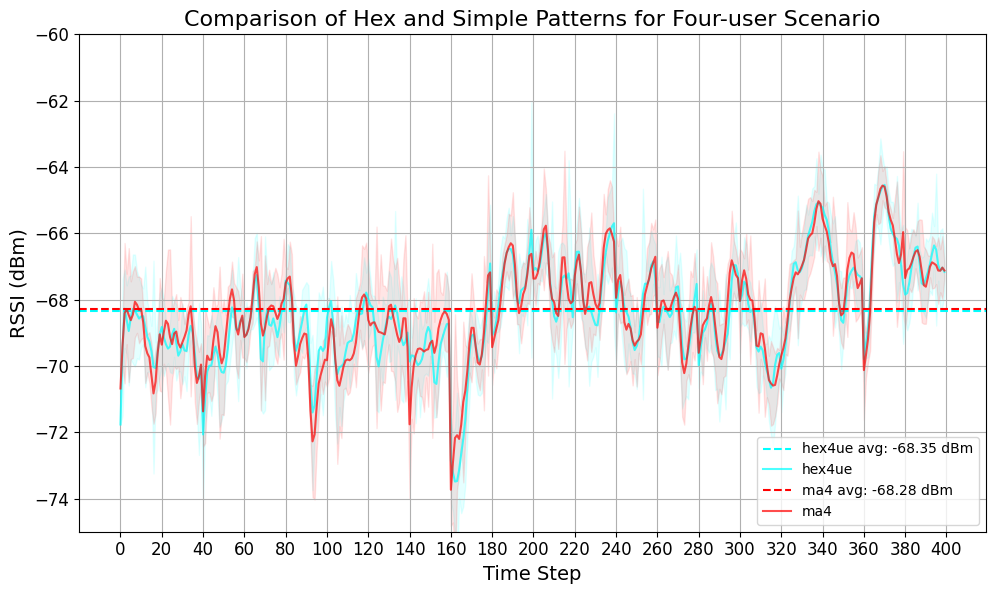

In [9]:
c2ue = dict(
    hex2ue=pattern_rssis["hex2ue"],
    ma2=pattern_rssis["ma2"],
)
plot_rssi(c2ue, "Comparison of Hex and Simple Patterns for Two-user Scenario", ymin=-75, ymax=-60, colors=pattern_colors)

c3ue = dict(
    hex3ue=pattern_rssis["hex3ue"],
    ma3=pattern_rssis["ma3"],
)
plot_rssi(c3ue, "Comparison of Hex and Simple Patterns for Three-user Scenario", ymin=-75, ymax=-60, colors=pattern_colors)

c4ue = dict(
    hex4ue=pattern_rssis["hex4ue"],
    ma4=pattern_rssis["ma4"],
)
plot_rssi(c4ue, "Comparison of Hex and Simple Patterns for Four-user Scenario", ymin=-75, ymax=-60, colors=pattern_colors)

### Plot RSSI between beam-focusing and column-based control

In [10]:
comparison_results = {
    "hex3ue": all_results["hex3ue"],
    "ma3": all_results["ma3"],
    "colr7": all_results["colr7"],
}
comparison_rssis = {}
for key, result in comparison_results.items():
    rss = result["agents", "cur_rss"].cpu()
    rss = [rss[..., 0, i:i+1] for i in range(rss.shape[-1])]
    rss = torch.cat(rss, dim=-1)
    print(f"rss shape for {key}: {rss.shape}")
    tmp = rss.mean(dim=-1)
    comparison_rssis[key] = 10 * torch.log10(tmp) + 30  # Convert to dBm
comparison_colors = {
        "hex3ue": "red",
        "ma3": "green",
        "colr7": "blue",
        }

plot_rssi(comparison_rssis, "Comparison Results", ymin=-80, ymax=-60, colors=comparison_colors)

KeyError: 'colr7'

### Reward Sensitivity

rss shape for f0: torch.Size([4, 1, 400, 3])
rss shape for f1: torch.Size([4, 1, 400, 3])
rss shape for f2: torch.Size([4, 1, 400, 3])
rss shape for f3: torch.Size([4, 1, 400, 3])
rss shape for f4: torch.Size([4, 1, 400, 3])


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Reward Sensitivity'}, xlabel='Time Step', ylabel='RSSI (dBm)'>)

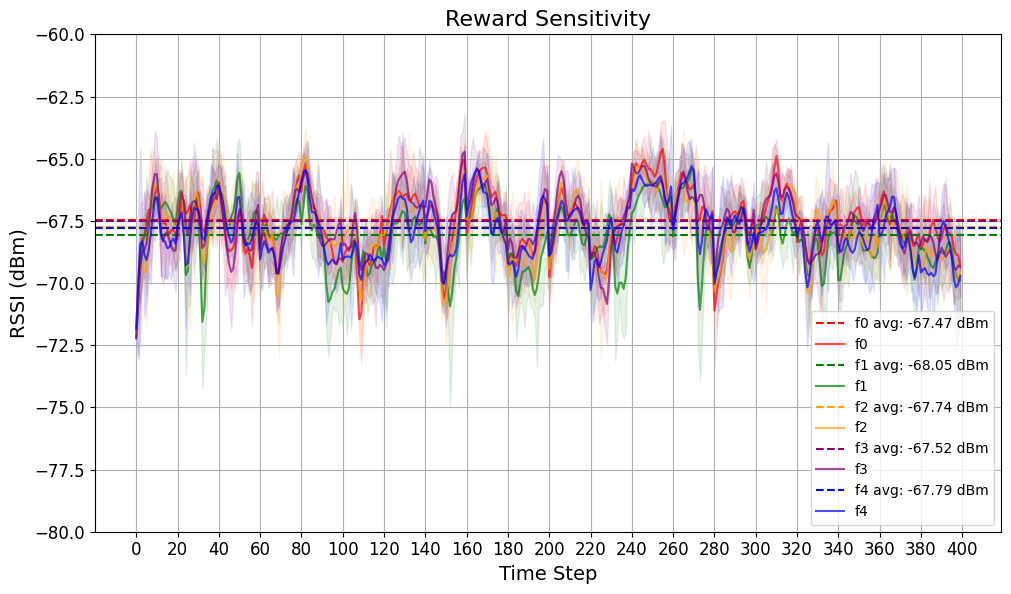

In [11]:
rew_sensitivity_results = {
    "f0": all_results["f0"],
    "f1": all_results["f1"],
    "f2": all_results["f2"],
    "f3": all_results["f3"],
    "f4": all_results["f4"],
}
rew_sensitivity_rssis = {}
for key, result in rew_sensitivity_results.items():
    rss = result["agents", "cur_rss"].cpu()
    rss = [rss[..., 0, i:i+1] for i in range(rss.shape[-1])]
    rss = torch.cat(rss, dim=-1)
    print(f"rss shape for {key}: {rss.shape}")
    tmp = rss.mean(dim=-1)
    rew_sensitivity_rssis[key] = 10 * torch.log10(tmp) + 30  # Convert to dBm
rew_sensitivity_colors = {
        "f0": "red",
        "f1": "green",
        "f2": "orange",
        "f3": "purple",
        "f4": "blue",
        }

plot_rssi(rew_sensitivity_rssis, "Reward Sensitivity", ymin=-80, ymax=-60, colors=rew_sensitivity_colors)

## Genetic Algorithm

In [ ]:
ga_results = torch.load('/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_ga_r5/best_focal_point_0.pt', weights_only=False)
print(f"fitness: {ga_results['fitness']}")
print(f"best rssi: {ga_results['best_rssi']}")
ga_results.keys()

fitness: (-70.77314758300781,)
best rssi: [-71.431076 -72.075714 -68.81264 ]


dict_keys(['best_focal_point', 'best_rssi', 'fitness', 'td', 'history'])

In [ ]:
def get_data_from_ga_files(ga_folder):
    ga_files = glob.glob(os.path.join(ga_folder, 'best_focal_point*.pt'))
    bests = []
    for file in ga_files:
        ga_results = torch.load(file, weights_only=False)
        bests.append(np.mean(ga_results['best_rssi']))
        return bests

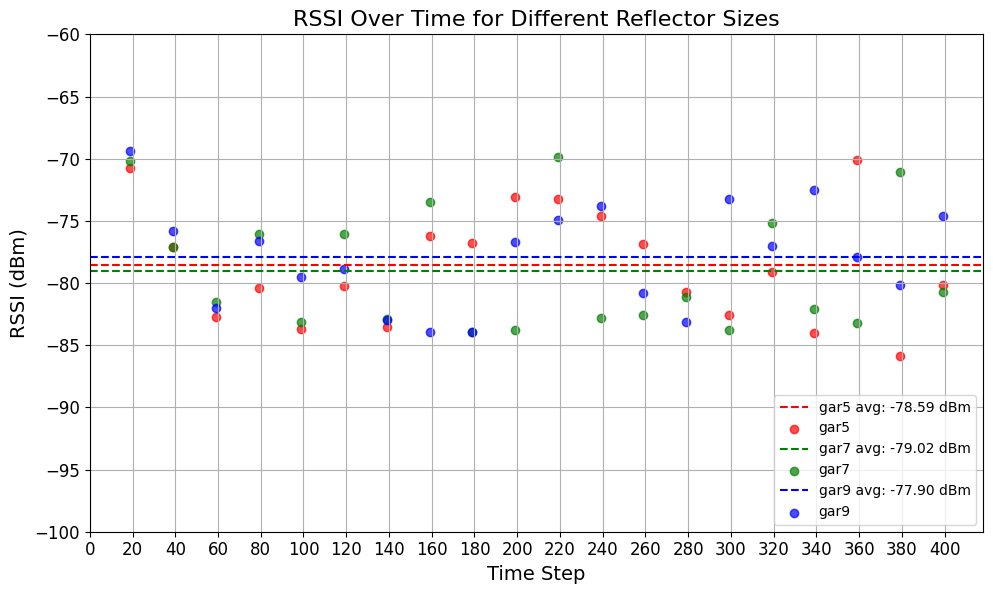

In [ ]:
ga_main_files = {
    "gar5": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_ga_r5",
    "gar7": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_ga_r7",
    "gar9": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_ga_r9",
    # "gar11": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_ga_r11",
}

ga_results = {}
for key, folder in ga_main_files.items():
    ga_files = glob.glob(os.path.join(folder, 'best_focal_point*.pt'))
    ga_files.sort(key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))
    ga_results[key] = []
    for file in ga_files:
        ga_result = torch.load(file, weights_only=False)
        ga_results[key].append(np.mean(ga_result['best_rssi']))

xvals = range(20, (len(ga_results['gar5']) + 1)* 20, 20) 
ga_colors = {
    "gar5": "red",
    "gar7": "green",
    "gar9": "blue",
    # "gar11": "orange",
}
xvals = {
    "gar5": range(19, (len(ga_results['gar5']) + 1) * 20 - 1, 20),
    "gar7": range(19, (len(ga_results['gar7']) + 1) * 20 - 1, 20),
    "gar9": range(19, (len(ga_results['gar9']) + 1) * 20 - 1, 20),
}
fig, ax = plot_rssi(ga_results, "RSSI Over Time for Different Reflector Sizes", 
          ymin=-100, ymax=-60, colors=ga_colors, xvals=xvals)

rss shape for r5: torch.Size([4, 1, 400, 3])


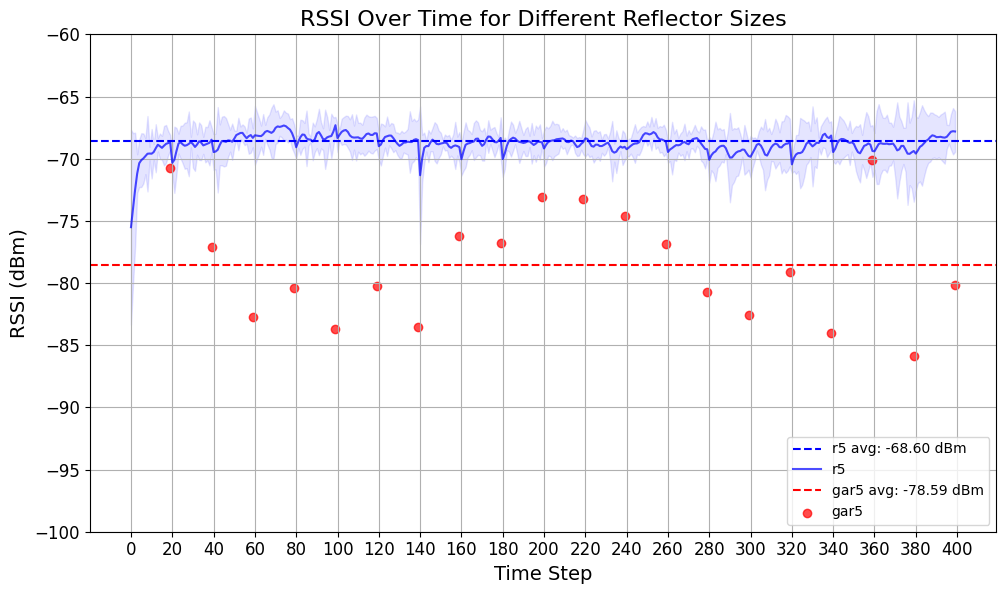

In [ ]:
ga_compare_results = {
    # "gar5": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_ga_r5",
    # "gar7": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_ga_r7",
    # "gar9": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_ga_r9",
    # "r11": all_results["r11"],
    # "r9": all_results["r9"],
    # "r7": all_results["r7"],
    "r5": all_results["r5"],
}
ga_compare_rssis = {}
for key, result in ga_compare_results.items():
    rss = result["agents", "cur_rss"].cpu()
    rss = [rss[..., 0, i:i+1] for i in range(rss.shape[-1])]
    rss = torch.cat(rss, dim=-1)
    print(f"rss shape for {key}: {rss.shape}")
    tmp = rss.mean(dim=-1)
    ga_compare_rssis[key] = 10 * torch.log10(tmp) + 30  # Convert to dBm
ga_compare_rssis['gar5'] = ga_results['gar5']
ga_compare_colors = {
        "gar5": "red",
        "r9": "green",
        "r7": "orange",
        "r5": "blue",
        }
xvals = {
    "gar5": range(19, (len(ga_results['gar5']) + 1) * 20 - 1, 20)
}
fig, ax = plot_rssi(ga_compare_rssis, "RSSI Over Time for Different Reflector Sizes", 
          ymin=-100, ymax=-60, colors=ga_compare_colors, xvals=xvals)